This Notebook is created to analyse the cloud data.
-
This is a colection of functions that help to differentiate between valid and false data.
-

ql_vertmax_20160530.nc
ql_vertmax_20160818.nc
ql_vertmax_20160610.nc
ql_vertmax_20160819.nc
ql_vertmax_20150606.nc
ql_vertmax_20160611.nc timestep 7*
ql_vertmax_20160830.nc bad start (seems caused by the simulation)
ql_vertmax_20150609.nc seems broken
ql_vertmax_20160619.nc seems broken
ql_vertmax_20170509.nc timestep 10*,11,17
ql_vertmax_20150627.nc timestep 6*
ql_vertmax_20160625.nc timestep 9*
ql_vertmax_20170605.nc timestep 7*,8,9,...(broken)
ql_vertmax_20150801.nc
ql_vertmax_20160719.nc
ql_vertmax_20160720.nc seems broken
ql_vertmax_20160518.nc seems broken

In [84]:
import numpy as np
from importlib import reload
import pandas as pd
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from random import random
import matplotlib
import sys

In [85]:
cloud_file = './data/ql_vertmax_20160830.nc'
cloud_data = Dataset(cloud_file)

Let's have a look at the resulting slopes using the 3 different distribution methods
-

n_clouds[ 2 ]: 52
nan_pos: [ 0  7  8  9 10 11 12 13 14 15]
nan_pos: [ 0  7  8  9 10 11 12 13 14 15]
nan_pos: [ 0  8  9 10 11 12 13 14 15]
nan_pos: [ 0  9 10 11 12 13 14 15]
nan_pos: [ 0 10 11 12 13 14 15]
nan_pos: [ 0 11 12 13 14 15]
nan_pos: [ 0 14 15]
nan_pos: [ 0 14 15]
min at pos 20
max at pos 4
CPU times: user 1.29 s, sys: 172 ms, total: 1.46 s
Wall time: 1.27 s


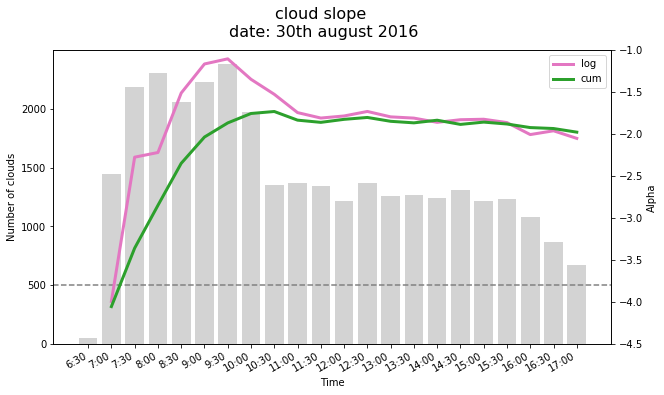

In [200]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt

thresh      = 1e-6
min_pixel   = 4
bin_n       = 15
bin_min     = 25
bin_max     = 2000
n_cloud_min = 500

n_clouds = []
time = np.arange(len(cloud_data.variables['time'][:]))
data = cloud_data.variables['ql'][time,:,:]
time, n_clouds, slope_lin, slope_log, slope_com = plot_cloud_alpha(data,time,bin_n,bin_min,bin_max,thresh,min_pixel,n_cloud_min)

slope_var = []

for i in range(len(slope_log)):
    if np.isnan(slope_log[i]):
        slope_var.append(slope_log[i])
    else:
        slope_var.append(np.abs(slope_log[i]-slope_com[i]))
        
print ('min at pos',np.nanargmin(slope_var)+len(cloud_data.variables['time'][:])-len(time))
print ('max at pos',np.nanargmax(slope_var)+len(cloud_data.variables['time'][:])-len(time))
time_labels = ['6:30','7:00','7:30','8:00','8:30','9:00','9:30','10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00','16:30','17:00']

axes = plt
axes.figure(figsize=(10,6))
axes.bar(time_labels, n_clouds, color='lightgrey')
axes.axhline(y=n_cloud_min, color='grey', linestyle='--')
#min_time = np.asarray(time_labels[np.asarray(n_clouds)<n_cloud_min])
#axes.bar(min_time, n_clouds, color='orange')

axes.xlabel('Time')
axes.ylabel('Number of clouds')
#axes.title('Power-law distribution with log scales')

axes2 = axes.twinx()

axes2.set_ylabel('Alpha')
#axes2.plot(time, slope_lin, linewidth=3, color='tab:red', label='lin')
axes2.plot(time_labels, slope_log, linewidth=3, color='tab:pink', label='log')
axes2.plot(time_labels, slope_com, linewidth=3, color='tab:green', label='cum')
plt.ylim(-4.5,-1)

plt.legend()
plt.suptitle('cloud slope \ndate: 30th august 2016', fontsize=16)
plt.gcf().autofmt_xdate()
plt.savefig('log_com_slopes_clouds_20160830.pdf',bbox_inches='tight')

Let's check out the timestep where the com and log slopes are furthest apart
-
[notice] cell above needs to be executed first, to obtain slopes_log and slope_com

min: 0.016928599718065263 at pos 20
max: 1.0834693974515197 at pos 4
slopes: -1.3476603136532255 -1.7548685005007512
timestep: 9 [ 7 ]
CPU times: user 1.57 s, sys: 20.3 ms, total: 1.59 s
Wall time: 1.59 s


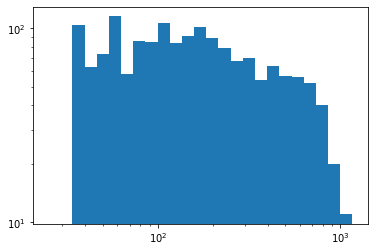

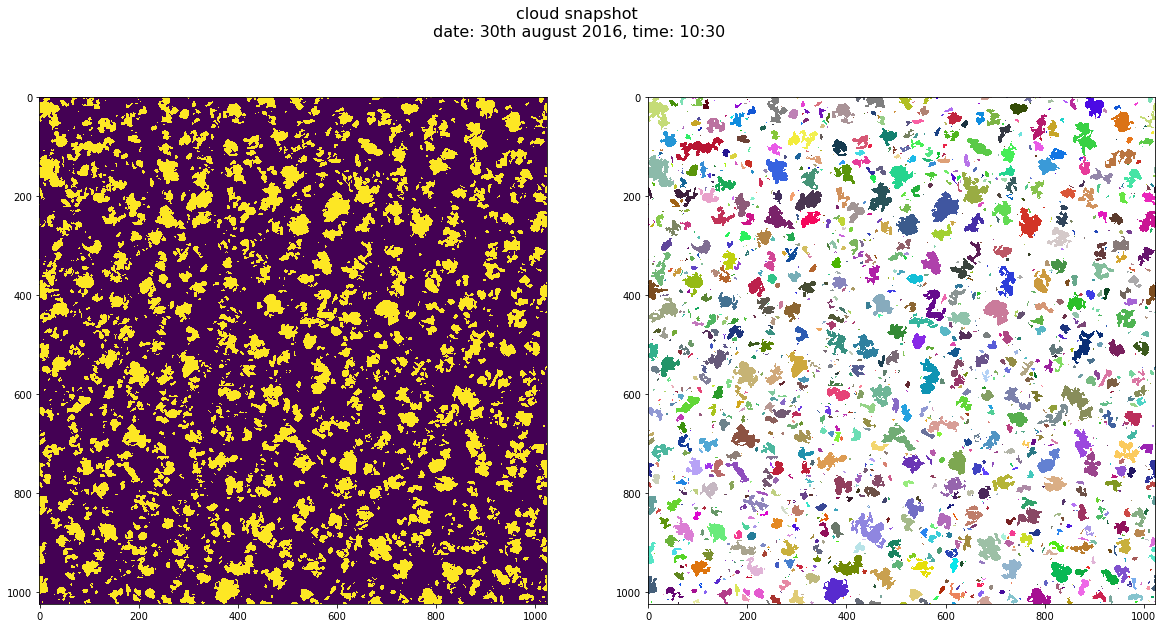

In [195]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
from random import random

hist_bins = 25       #number of bins used for the histogram
buffer_size = .5     #buffer_size given as a percentage of the full domain's length

colors = [(0.5,0.5,0.5)] + [(random(),random(),random()) for i in range(1000)]
random_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('random_cmap', colors, N=1000)

absolute = []
for i in range(len(slope_log)):
    if np.isnan(slope_log[i]):
        absolute.append(slope_log[i])
    else:
        absolute.append(np.abs(slope_log[i]-slope_com[i]))
        
timestep = 9 #np.nanargmax(absolute)+len(cloud_data.variables['time'][:])-len(time)

print ('min:',np.nanmin(absolute),'at pos',np.nanargmin(absolute)+len(cloud_data.variables['time'][:])-len(time))
print ('max:',np.nanmax(absolute),'at pos',np.nanargmax(absolute)+len(cloud_data.variables['time'][:])-len(time))

print ('slopes:',slope_log[timestep-len(cloud_data.variables['time'][:])+len(time)], slope_com[timestep-len(cloud_data.variables['time'][:])+len(time)])
print ('timestep:',timestep,'[',timestep-len(cloud_data.variables['time'][:])+len(time),']')

# marks everything above ref_min as a cloud
cloud_2D_mask = np.zeros_like(cloud_data.variables['ql'][timestep,:,:])
cloud_2D_mask[cloud_data.variables['ql'][timestep,:,:] > thresh] = 1

# calculates how many clouds exist in cloud_2D_mask, returns total number of clouds
labeled_clouds, A_buf, n_buffer, cloud_center_x, cloud_center_y, cloud_pixels = cluster_2D(cloud_2D_mask,buffer_size)

#Grosse jeder wolken
label, cl_pixels = np.unique(labeled_clouds.ravel(),return_counts=True)
cl_size = np.sqrt(cl_pixels*25.*25.)

plt.hist(cl_size[1:],bins=np.logspace(np.log10(min(cl_size[1:])),np.log10(max(cl_size[1:])), hist_bins+1))
plt.yscale('log')
plt.xscale('log')

masked_clouds = np.ma.masked_where(labeled_clouds<1,labeled_clouds)
fig,ax = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('cloud snapshot \ndate: 30th august 2016, time: 10:30', fontsize=16)

im1  =ax[0].imshow(cloud_2D_mask)
im1  =ax[1].imshow(masked_clouds,cmap=random_cmap)
#plt.savefig('cloud_snapshot_ts%i_20160830.pdf'%timestep,bbox_inches='tight')

Now where we've seen a snapshot of the cloud field, let's investigate the slope calculation
-
The areas covered in light grey have been filtered and did not influence the slope calculation

[notice] timestep should have been selected by the cell abow. Otherwise timestep needs to be specified.

number of clouds: 1213
25.0
timestep 13
CPU times: user 2.25 s, sys: 168 ms, total: 2.42 s
Wall time: 2.15 s


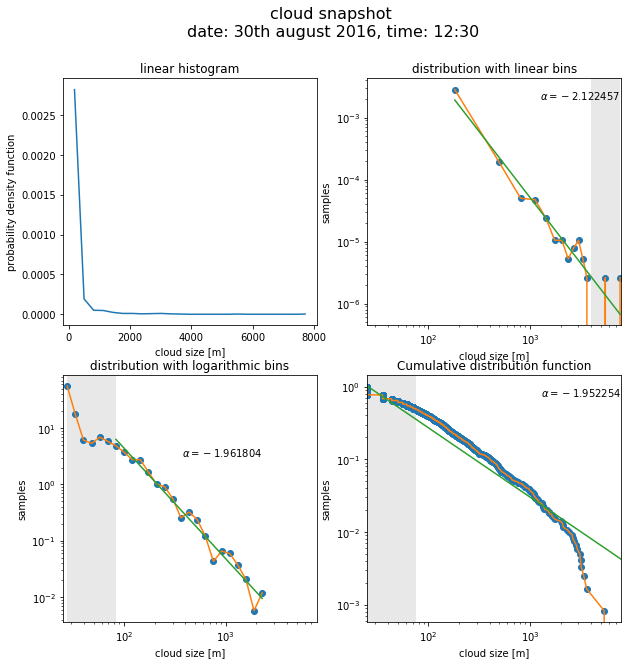

In [193]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt

timestep = 13
thresh = 1e-6
min_pixel = 9
bin_n = 25
bin_min = 25
bin_max = 2500
show_plt = True

fig,m1,m2,m3 = cloud_size_dist('ql',timestep,bin_n,bin_min,bin_max,thresh,cloud_data,min_pixel,show_plt)
fig.suptitle('cloud snapshot \ndate: 30th august 2016, time: 12:30', fontsize=16)
plt.savefig('cloud_slopes_4rer_ts%i_20160830.pdf'%timestep,bbox_inches='tight')

print('timestep',timestep)

The next test uses slope calculation described in Neggers et. al, 2018
-
The slopes are calculated for the whole timeseries

If log_binning = False is selected the algorythm uses linear bins

[notice] timestep should have been selected by the cell abow. Otherwise timestep needs to be specified.

min cloud area: 75.0 
max cloud area: 8689.109563125558
timestep: 13
-1.0131368741983888
-0.9053291363632247
-1.0860894862630501
-1.4161192043205448


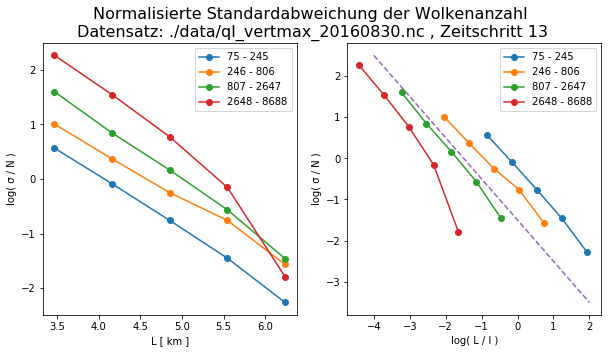

CPU times: user 3.42 s, sys: 523 ms, total: 3.94 s
Wall time: 4.02 s


In [25]:
%%time
import numpy as np
from importlib import reload
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

timestep = 13

subdomains = [2,4,8,16,32]
log_binning = True

inbetween_subs = True
n_bins = 4                 #number of bins per subdomain wich the histogram holds

min_pixel = 9
buffer_size = .5           #buffer_size given as a percentage of the full domain's length

l2D = cloud_data.variables['ql'][timestep,:,:]
l2D_bi = np.zeros_like(l2D).astype(int)
l2D_bi[l2D>1e-6]=1

labeled_clouds, l2D_bi_buf, n_buffer, cloud_center_x, cloud_center_y, cloud_pixels = cluster_2D(l2D_bi,buffer_size)

cloud_size = np.sqrt(np.asarray(cloud_pixels))*25.
cloud_center_x = np.asarray(cloud_center_x)
cloud_center_y = np.asarray(cloud_center_y)

new_arr = np.zeros_like(l2D_bi).astype(float)
new_arr[cloud_center_x,cloud_center_y] = cloud_size

var = []
N_mean =  []
L = []

cloud_area_min = np.sqrt(min_pixel)*25.
cloud_area_max = np.max(cloud_size)
print ('min cloud area:',cloud_area_min,'\nmax cloud area:',cloud_area_max)
print ('timestep:',timestep)

for n_x_slices in subdomains:
    n_y_slices = n_x_slices
    x_split = int(l2D_bi.shape[0] / n_x_slices)
    y_split = int(l2D_bi.shape[0] / n_y_slices)
    
    dist = []
    var_sub = []
    N_mean_sub = []
    
    L.append(len(new_arr)/n_x_slices)
    for y in range(n_y_slices):
        for x in range(n_x_slices):
            tmp_sub = new_arr[y*y_split:(y+1)*y_split,x*x_split:(x+1)*x_split]
            tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
            if (log_binning):
                n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
            else:
                n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
            dist.append(n_cl_per_bin)
            
    if inbetween_subs:
        for y in range(n_y_slices):
            for x in range(n_x_slices-1):
                tmp_sub = new_arr[y*y_split:(y+1)*y_split,int((x+.5)*x_split):int((x+1.5)*x_split)]
                tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                if log_binning:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                else:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                dist.append(n_cl_per_bin)

        for y in range(n_y_slices-1):
            for x in range(n_x_slices):
                tmp_sub = new_arr[int((y+.5)*y_split):int((y+1.5)*y_split),x*x_split:(x+1)*x_split]
                tmp_cl_size = tmp_sub[tmp_sub>np.sqrt(min_pixel)*25.]
                if log_binning:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
                else:
                    n_cl_per_bin, l = np.histogram(tmp_cl_size, bins=n_bins,range=(cloud_area_min, cloud_area_max))
                dist.append(n_cl_per_bin)

    dist = np.asarray(dist)

    #plt.hist(tmp_cl_size,bins=np.logspace(np.log10(cloud_area_min),np.log10(cloud_area_max), n_bins+1),range=(cloud_area_min, cloud_area_max))
    #plt.show()
    
    for i in range(n_bins):
        N_mean_sub.append(np.mean(dist[:,i]))
        var_sub.append(np.sqrt(np.sum((dist[:,i]-N_mean_sub[i])**2)/len(dist[:,0])))

    var.append(var_sub)
    N_mean.append(N_mean_sub)
    
N_mean = np.asarray(N_mean)
var = np.asarray(var)

fig,ax = plt.subplots(1,2,figsize=(10,5))
y_axis = np.log(var/N_mean)

for i in range(n_bins):
    x_axis = np.log(L/l[i])
    m, b = np.polyfit(x_axis, y_axis[:,i], 1)
    print(m)
    im1 = ax[0].plot(np.log(L),y_axis[:,i], '-o', label='%i - %i'%(int(l[i]),int(l[i+1])-1))
    im2 = ax[1].plot(x_axis,y_axis[:,i], '-o', label='%i - %i'%(int(l[i]),int(l[i+1])-1))
    
im1 = ax[1].plot([-4,2],np.polyval([-1,-1.5],[-4,2]),'--')

fig.suptitle('Normalisierte Standardabweichung der Wolkenanzahl \nDatensatz: %s , Zeitschritt %i' % (cloud_file,timestep), fontsize=16)

ax[0].legend(loc='best')
ax[0].set_xlabel('L [ km ]')
ax[0].set_ylabel('log( σ / N )')

ax[1].legend(loc='best')
ax[1].set_xlabel('log( L / l )')
ax[1].set_ylabel('log( σ / N )')

#plt.savefig('organization_clouds_ts%i_20160830.png'%timestep)
plt.show()

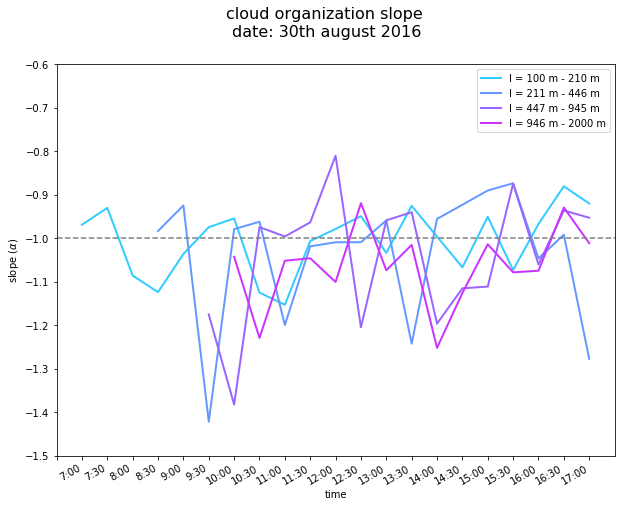

CPU times: user 23.2 s, sys: 376 ms, total: 23.5 s
Wall time: 23.4 s


In [204]:
%%time
import numpy as np
from importlib import reload
import organization
from organization import *
reload(organization)
import slopes_and_binning
from slopes_and_binning import *
reload(slopes_and_binning)
import cloud_and_plumes_slopes
from cloud_and_plumes_slopes import *
reload(cloud_and_plumes_slopes)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

subdomains = [2,4,8,16,32]  #number of subdomains in both x and y-axis
n_bins = 4                  #number of bins (cloud size) which devide the whole cloud size range
log_binning = True
inbetween_subs = True
buffer_size = .5            #buffer_size given as a percentage of the full domain's length. this buffer is needed in cluster_2D() to compensate periodic boundaries

percentile = False           #if set to False min_size and max_size will be used as boundaries for the size distribution
lower_percentile = 25
upper_percentile = 99
min_size = 100
max_size = 2002

time_len = len(cloud_data.variables['ql'][:,0,0])

cloud_size = []
cloud_center_x = []
cloud_center_y = []
size = []
valid_time = []
for timestep in range(time_len):
    l2D = cloud_data.variables['ql'][timestep,:,:]
    l2D_bi = np.zeros_like(l2D).astype(int)
    l2D_bi[l2D>1e-6]=1
    if (len(l2D_bi[l2D_bi==1])>100):
        valid_time.append(timestep)
        labeled_clouds, l2D_bi_buf, n_buffer, center_x, center_y, cloud_pixels = cluster_2D(l2D_bi,buffer_size)
        cloud_size.append(np.sqrt(cloud_pixels)*25.)
        cloud_center_x.append(center_x)
        cloud_center_y.append(center_y)
        size.extend(np.sqrt(cloud_pixels)*25.)
    else:
        cloud_size.append(np.nan)
        cloud_center_x.append(np.nan)
        cloud_center_y.append(np.nan)

domain_size = len(l2D)
if percentile:
    min_size = np.percentile((size), lower_percentile)
    print(lower_percentile,'th percentile -> ',np.round(min_size,1),'m')
    max_size = np.percentile((size), upper_percentile)
    print(upper_percentile,'th percentile -> ',np.round(max_size,1),'m')
    
f = variability(cloud_center_x, cloud_center_y, cloud_size, valid_time, domain_size, subdomains, n_bins, min_size, max_size, log_binning, inbetween_subs, show_subs=False)
plt.suptitle('cloud organization slope \ndate: 30th august 2016', fontsize=16)
plt.savefig('organization_clouds_20160830.pdf',bbox_inches='tight')
plt.show()

In [10]:
cloud_data.variables['time'][:]

masked_array(data=[    0.,   100.,   100.,   100.,   100.,   100., 10800.,
                   10100., 10100., 10100., 10100., 10100., 21600., 20100.,
                   20100., 20100., 20100., 30600., 30100., 30100., 30100.,
                   30100., 30100., 41400.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)